# Air Quality Analysis

## Introduction

Air quality is a critical determinant of public health and environmental well-being. With the rise of urbanization and industrial activities, monitoring and analyzing air quality has become essential for informed decision-making and policy implementation. This project leverages historical air quality data to build a predictive model for air pollutants and analyze their impact over time.

---

## Dataset Details

### Source
The dataset used in this analysis comes from the **OpenAQ platform**, specifically for the **New Delhi (GK1 - Oberoi Terrace)** location.

### Parameters
The dataset contains the following parameters, essential for assessing air quality:
- **PM1**: Fine particulate matter (µg/m³)
- **PM2.5**: Particulate matter smaller than 2.5 µm (µg/m³)
- **PM10**: Particulate matter smaller than 10 µm (µg/m³)
- **RH**: Relative Humidity (%)
- **Temperature**: Temperature (°C)
- **PM0.3**: Ultra-fine particulate count (particles/cm³)

### Data Range
- **From**: November 1, 2024
- **To**: December 12, 2024

---

## Data Preprocessing

### Loading and Reshaping
1. The raw dataset was loaded and irrelevant columns such as `country_iso`, `isMobile`, and `isMonitor` were dropped.
2. A **pivot table** was created to reshape the dataset, aggregating pollutant values for each timestamp. This allows each row to represent a single time point with values for all pollutants.

### Missing Values
The dataset was checked for missing values to ensure data consistency and accuracy. Missing values, if any, can impact the model's predictions.

---

## Splitting Data

### Train-Test Split
- **Training Data**: All records before December 5, 2024.
- **Testing Data**: All records from December 5, 2024, onward.

### Normalization
The data was normalized using a **MinMaxScaler**, which scales values to a range of 0 to 1. This ensures that all parameters contribute equally to the model's learning process.

---

## Model Design and Training

### Model Architecture
We implemented an **LSTM (Long Short-Term Memory)** neural network, which is ideal for time-series data due to its ability to capture temporal dependencies. The architecture includes:
1. **Input Layer**: Takes time-series input with 3 time steps and multiple features (pollutants).
2. **Three LSTM Layers**: 
   - Capture sequential dependencies.
   - Include **Dropout layers** to prevent overfitting.
3. **Dense Layers**:
   - Transform LSTM outputs into predictions for all pollutants.

### Hyperparameters
- **Epochs**: 1000
- **Batch Size**: 32
- **Learning Rate**: 0.001 (using Adam optimizer)

### Cross-Validation
We used **TimeSeriesSplit** for cross-validation to validate the model across multiple time splits, ensuring robustness in predictions.

### Callbacks
- **EarlyStopping**: Halts training if validation performance stops improving.
- **ReduceLROnPlateau**: Reduces the learning rate dynamically when validation performance stagnates.

---

## Evaluation Metrics

### Metrics Used
1. **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
2. **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions.

### Results
The model's performance was evaluated on both training and testing datasets, yielding the following metrics:
- **MSE**: A lower value indicates better performance.
- **MAE**: Indicates how close predictions are to actual values on average.

---

## Visualizations

### True vs. Predicted Values
For each parameter, scatter plots and joint plots show the relationship between true and predicted values. A close alignment between points and the diagonal line indicates good model performance.

### Pair Plots
Pair plots illustrate the relationships between pollutants in the true dataset. For example:
- A high correlation between **PM2.5** and **PM10** is expected, as both represent particulate matter.

### Heatmaps
1. **Correlation Heatmap (True Values)**:
   - Shows how parameters correlate with one another.
   - Strong correlations suggest interdependence, e.g., temperature and RH.
2. **Correlation Heatmap (Predicted Values)**:
   - Indicates how well the model captures parameter relationships.

---

## Insights and Conclusion

### Model Insights
- **LSTM for Time-Series**: The use of LSTM layers allowed the model to effectively capture temporal trends in the dataset.
- **Dropout Regularization**: Helped mitigate overfitting and ensured generalization to unseen data.
- **Cross-Validation**: Validated the model across multiple splits, improving robustness.

### Key Findings
1. **High Correlation**:
   - **PM2.5** and **PM10** are strongly correlated due to their physical and chemical similarities.
   - **Temperature** and **RH** show an inverse relationship.
2. **Accurate Predictions**:
   - The model performed well in predicting pollutants like **PM2.5** and **PM10**, as evident from scatter plots and low error metrics.


In [82]:
# Importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [83]:
delhi_file_path = r"D:\Small World\AQI\delhi.csv"
# Load the dataset
delhi_data = pd.read_csv(delhi_file_path)
# Drop irrelevant columns
delhi_data = delhi_data.drop(columns=['country_iso', 'isMobile', 'isMonitor'])
# Reshape the dataset: Pivot to aggregate all parameters for each timestamp
delhi_pivot = delhi_data.pivot_table(
    index='datetimeUtc', 
    columns='parameter', 
    values='value'
).reset_index()
# Display reshaped dataset information
print("Reshaped Dataset (Pivoted) Information:")
print(delhi_pivot.info())

print("\nFirst 5 Rows of the Reshaped Dataset:")
print(delhi_pivot.head())

# Save the reshaped dataset for further analysis
reshaped_file_path = "D:/Small World/AQI/delhi_reshaped_data.csv"
delhi_pivot.to_csv(reshaped_file_path, index=False)
print(f"\nReshaped dataset saved to {reshaped_file_path}")


Reshaped Dataset (Pivoted) Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetimeUtc       1000 non-null   object 
 1   pm1               1000 non-null   float64
 2   pm10              1000 non-null   float64
 3   pm25              1000 non-null   float64
 4   relativehumidity  1000 non-null   float64
 5   temperature       1000 non-null   float64
 6   um003             1000 non-null   float64
dtypes: float64(6), object(1)
memory usage: 54.8+ KB
None

First 5 Rows of the Reshaped Dataset:
parameter           datetimeUtc         pm1        pm10        pm25  \
0          2024-11-01T01:00:00Z  176.681943  374.554212  355.163246   
1          2024-11-01T02:00:00Z  143.084524  284.474408  269.098067   
2          2024-11-01T03:00:00Z  111.724553  210.518503  200.632838   
3          2024-11-01T04:00:00Z   91.041964  171.22

In [84]:
# File path for the updated Delhi dataset
updated_delhi_file_path = r"D:\Small World\AQI\delhi_reshaped_data.csv"  

# Reading the updated dataset into a Pandas DataFrame
updated_delhi_data = pd.read_csv(updated_delhi_file_path)

# Display initial data information
print("Updated Dataset Information:")
print(updated_delhi_data.info())

print("\nFirst 5 Rows of the Updated Dataset:")
print(updated_delhi_data.head())

print("\nShape of the Updated Dataset:", updated_delhi_data.shape)

print("\nStatistical Description of Numerical Columns:")
print(updated_delhi_data.describe())

# Checking for missing values
print("\nMissing Values in Each Column:")
print(updated_delhi_data.isnull().sum())

Updated Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetimeUtc       1000 non-null   object 
 1   pm1               1000 non-null   float64
 2   pm10              1000 non-null   float64
 3   pm25              1000 non-null   float64
 4   relativehumidity  1000 non-null   float64
 5   temperature       1000 non-null   float64
 6   um003             1000 non-null   float64
dtypes: float64(6), object(1)
memory usage: 54.8+ KB
None

First 5 Rows of the Updated Dataset:
            datetimeUtc         pm1        pm10        pm25  relativehumidity  \
0  2024-11-01T01:00:00Z  176.681943  374.554212  355.163246         51.265328   
1  2024-11-01T02:00:00Z  143.084524  284.474408  269.098067         51.463988   
2  2024-11-01T03:00:00Z  111.724553  210.518503  200.632838         44.057986   
3  2024-11-01T04:00:00Z

In [85]:
# Split the data into training and testing based on the date range
train_data = updated_delhi_data[updated_delhi_data['datetimeUtc'] < '2024-12-05T00:00:00Z']
test_data = updated_delhi_data[updated_delhi_data['datetimeUtc'] >= '2024-12-05T00:00:00Z']

# Drop the 'datetimeUtc' column as it's not a feature for model training
train_features = train_data.drop(columns=['datetimeUtc'])
test_features = test_data.drop(columns=['datetimeUtc'])

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Convert the normalized data into arrays
train_array = np.array(train_scaled)
test_array = np.array(test_scaled)

# Output shapes for verification
print("Training Data Shape:", train_array.shape)
print("Testing Data Shape:", test_array.shape)


Training Data Shape: (815, 6)
Testing Data Shape: (185, 6)


In [86]:
# Check for null values in the scaled training and testing data
train_null_check = np.isnan(train_array).sum()
test_null_check = np.isnan(test_array).sum()

# Display results
print("Null Values in Training Data:", train_null_check)
print("Null Values in Testing Data:", test_null_check)


Null Values in Training Data: 0
Null Values in Testing Data: 0


In [87]:
# Define the function to split the sequence into sets of n values
def split_sequence(sequence, n_steps):
    """
    Splits a sequence into groups of n_steps for time series modeling.
    
    Args:
        sequence (array): The input sequence of data.
        n_steps (int): The number of steps to consider in each split.

    Returns:
        X, y: Arrays of input-output pairs for time series modeling.
    """
    X, y = [], []
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_idx = i + n_steps
        # If we have reached beyond the sequence length, stop
        if end_idx > len(sequence) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Example usage of split_sequence
n_steps = 3  # Define the number of steps for splitting
X_train, y_train = split_sequence(train_array, n_steps)
X_test, y_test = split_sequence(test_array, n_steps)

# Reshape input to the format [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Output shapes for verification
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (812, 3, 6)
Shape of y_train: (812, 6)
Shape of X_test: (182, 3, 6)
Shape of y_test: (182, 6)


In [88]:
# Define the model structure with additional hidden layers and Dropout
def create_optimized_lstm_model(input_shape, dropout_rate=0.3):
    model = Sequential()
    # Add first LSTM layer with Dropout
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    # Add second LSTM layer with Dropout
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    # Add third LSTM layer
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Add Dense layer for hidden processing
    model.add(Dense(64, activation='relu'))
    # Add Dense layer for output
    model.add(Dense(y_train.shape[1]))  # Predicting all features
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_metrics = []

# ReduceLROnPlateau and EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

for train_idx, val_idx in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
    
    # Create a new model for each fold
    model = create_optimized_lstm_model((X_train.shape[1], X_train.shape[2]))
    
    # Fit the model
    history = model.fit(
        X_train_cv, y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        epochs=5000,
        batch_size=32,
        verbose=0,
        callbacks=[lr_scheduler, early_stopping]
    )
    
    # Evaluate on validation data
    y_val_pred = model.predict(X_val_cv)
    mse = mean_squared_error(y_val_cv, y_val_pred)
    mae = mean_absolute_error(y_val_cv, y_val_pred)
    print(f"Fold Metrics - MSE: {mse:.5f}, MAE: {mae:.5f}")
    cv_metrics.append({'mse': mse, 'mae': mae})

# Average metrics across folds
avg_metrics = {
    'mse': np.mean([m['mse'] for m in cv_metrics]),
    'mae': np.mean([m['mae'] for m in cv_metrics]),
}
print(f"\nAverage CV Metrics - MSE: {avg_metrics['mse']:.5f}, MAE: {avg_metrics['mae']:.5f}")

# Final model training on the full training set
final_model = create_optimized_lstm_model((X_train.shape[1], X_train.shape[2]))
final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5000,
    batch_size=32,
    verbose=0,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate on the test set
y_test_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print final metrics
print(f"\nTest Metrics - MSE: {test_mse:.5f}, MAE: {test_mae:.5f}")


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Fold Metrics - MSE: 0.01179, MAE: 0.07912


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Fold Metrics - MSE: 0.01854, MAE: 0.10732


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Fold Metrics - MSE: 0.01089, MAE: 0.08132


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Fold Metrics - MSE: 0.01432, MAE: 0.10130


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Fold Metrics - MSE: 0.00608, MAE: 0.06093

Average CV Metrics - MSE: 0.01233, MAE: 0.08600


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

Test Metrics - MSE: 0.01170, MAE: 0.07561


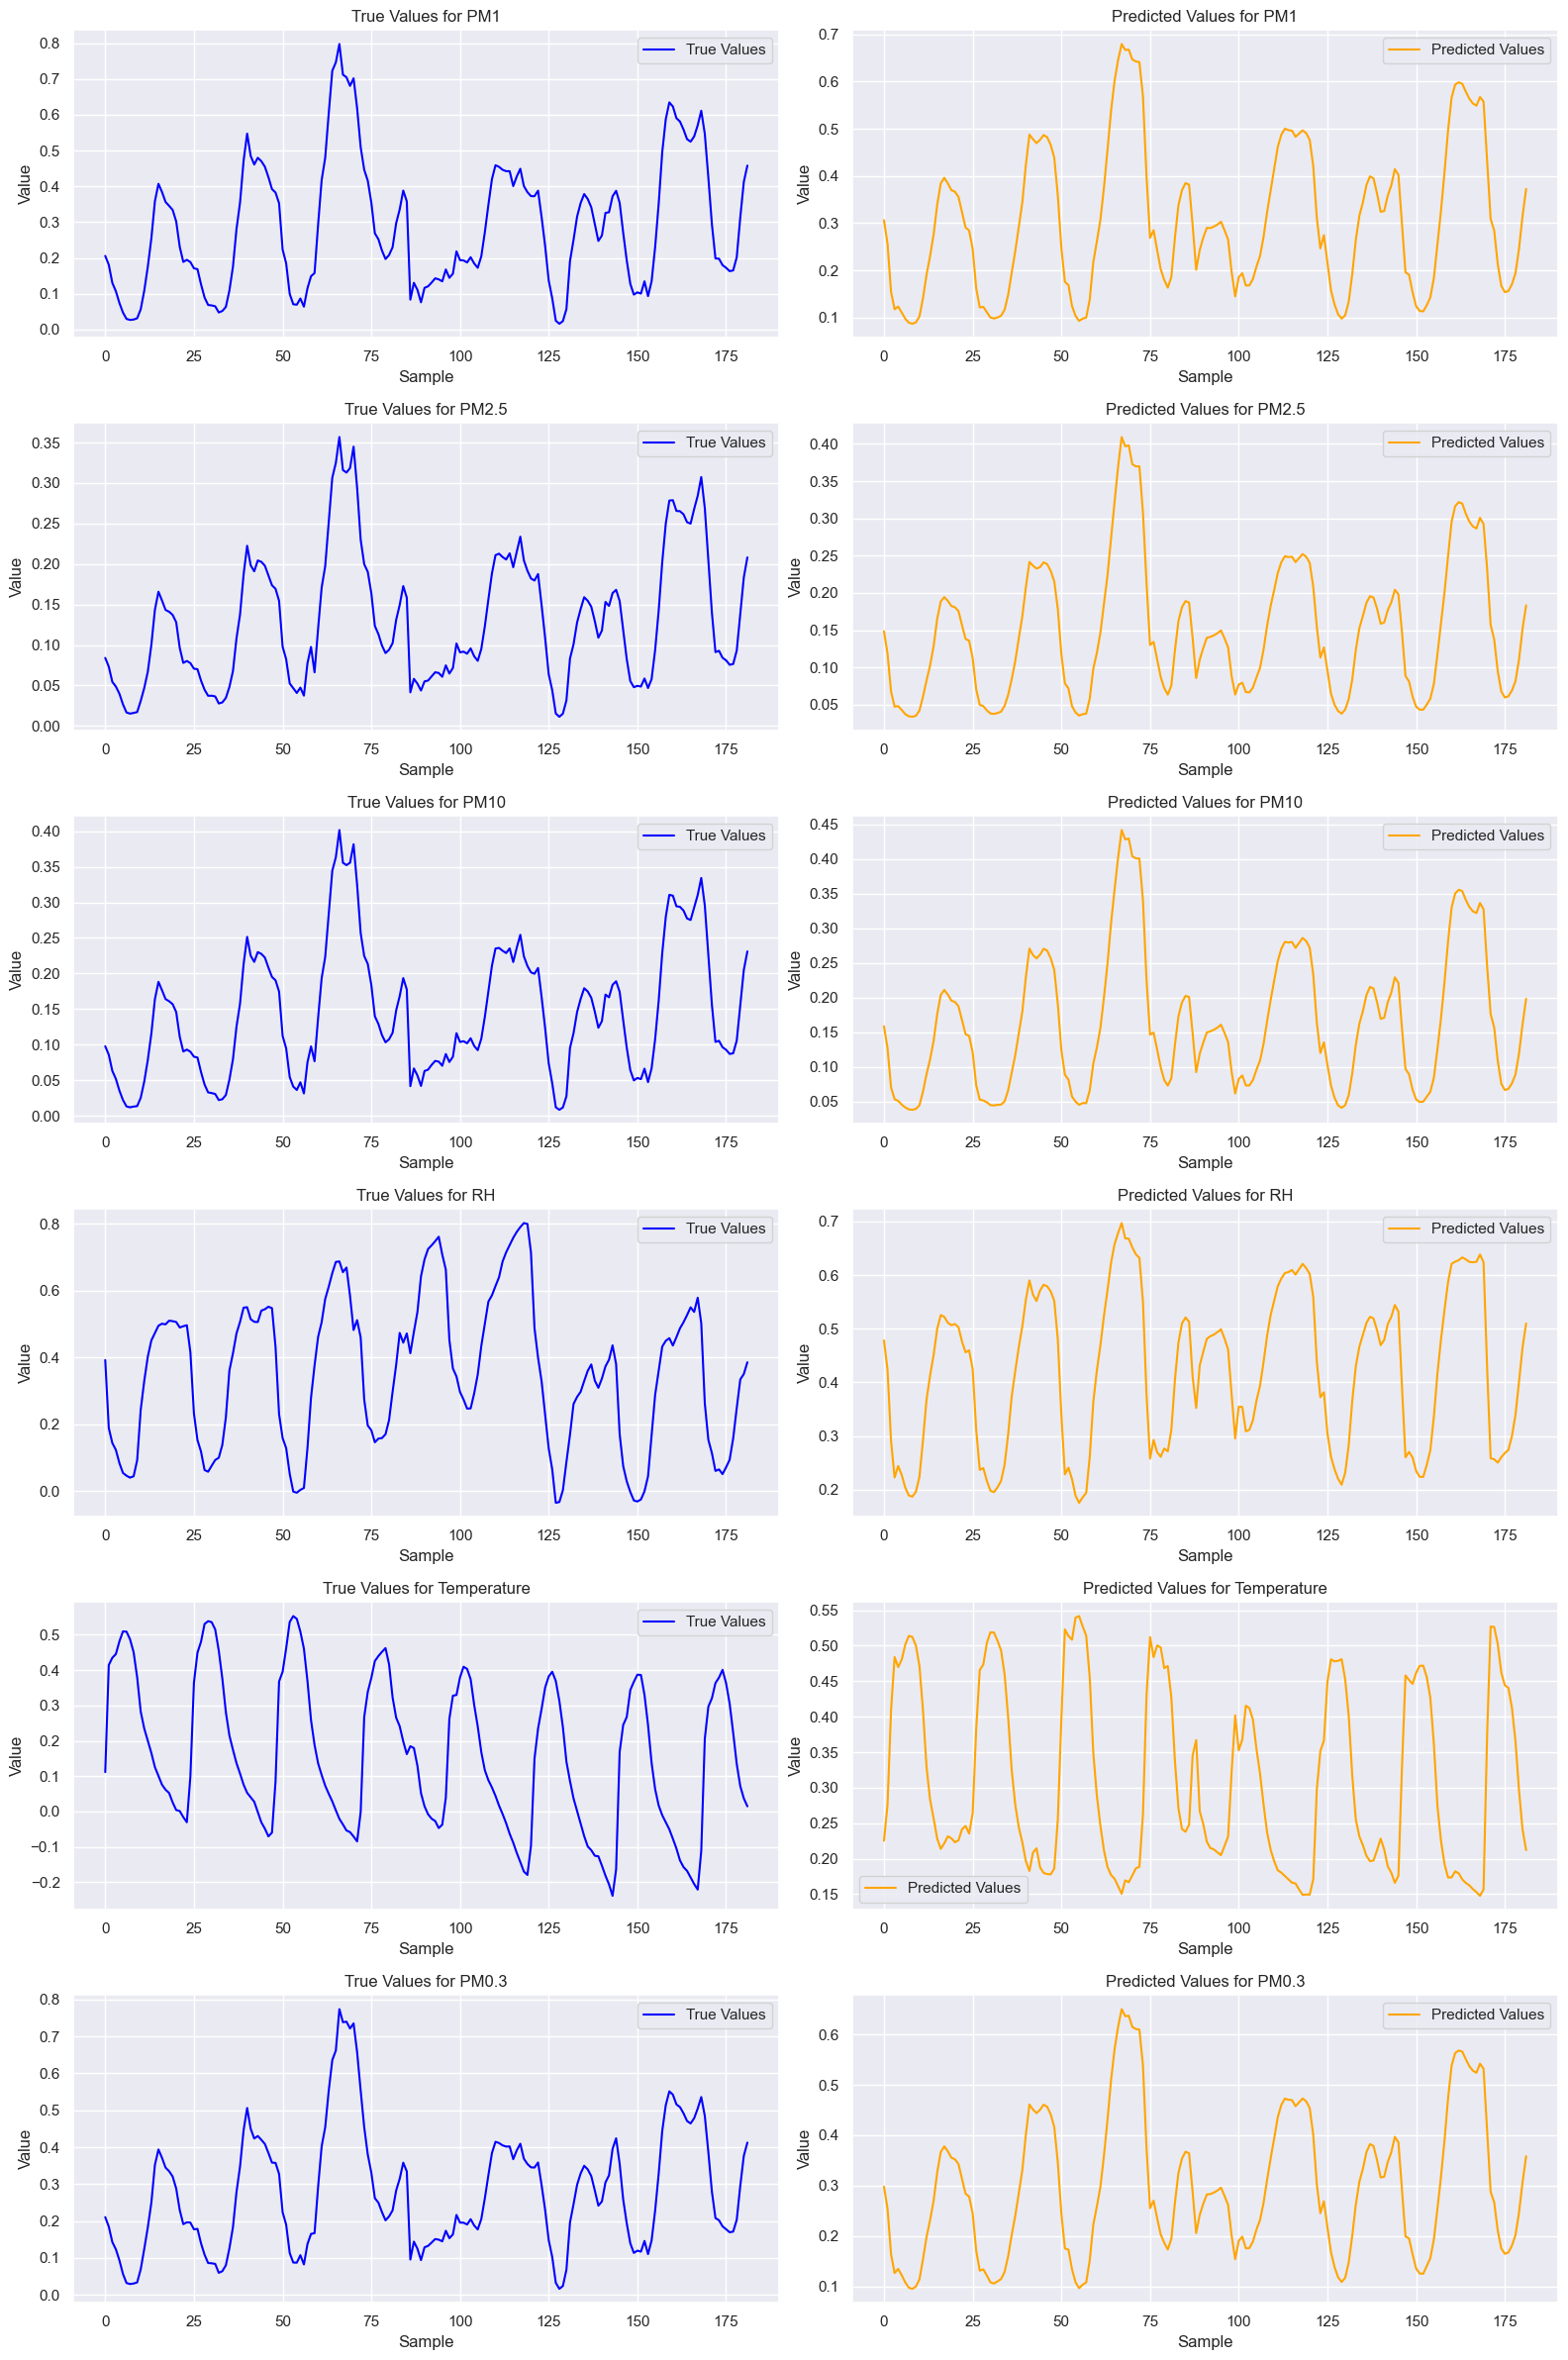

In [89]:
def plot_all_features_with_names(y_true, y_pred, parameters):
    """
    Plots the true and predicted values for all parameters side by side.
    
    Args:
        y_true (array): True values.
        y_pred (array): Predicted values.
        parameters (list): List of parameter names corresponding to the features.
    """
    num_features = y_true.shape[1]
    plt.figure(figsize=(16, 4 * num_features))
    
    for i in range(num_features):
        # Create subplots for each parameter
        plt.subplot(num_features, 2, 2 * i + 1)
        plt.plot(y_true[:, i], label="True Values", color='blue')
        plt.title(f"True Values for {parameters[i]}")
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.legend()
        
        plt.subplot(num_features, 2, 2 * i + 2)
        plt.plot(y_pred[:, i], label="Predicted Values", color='orange')
        plt.title(f"Predicted Values for {parameters[i]}")
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# List of parameter names
parameters = ['PM1', 'PM2.5', 'PM10', 'RH', 'Temperature', 'PM0.3']

# Plot true vs predicted values for all parameters
plot_all_features_with_names(y_test, y_test_pred, parameters)


In [90]:
# Evaluate the model on training and testing data
train_loss, train_acc = final_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)

# Print training and testing accuracy
print('Train Accuracy: %.5f, Test Accuracy: %.5f' % (train_acc, test_acc))


Train Accuracy: 0.04656, Test Accuracy: 0.07561


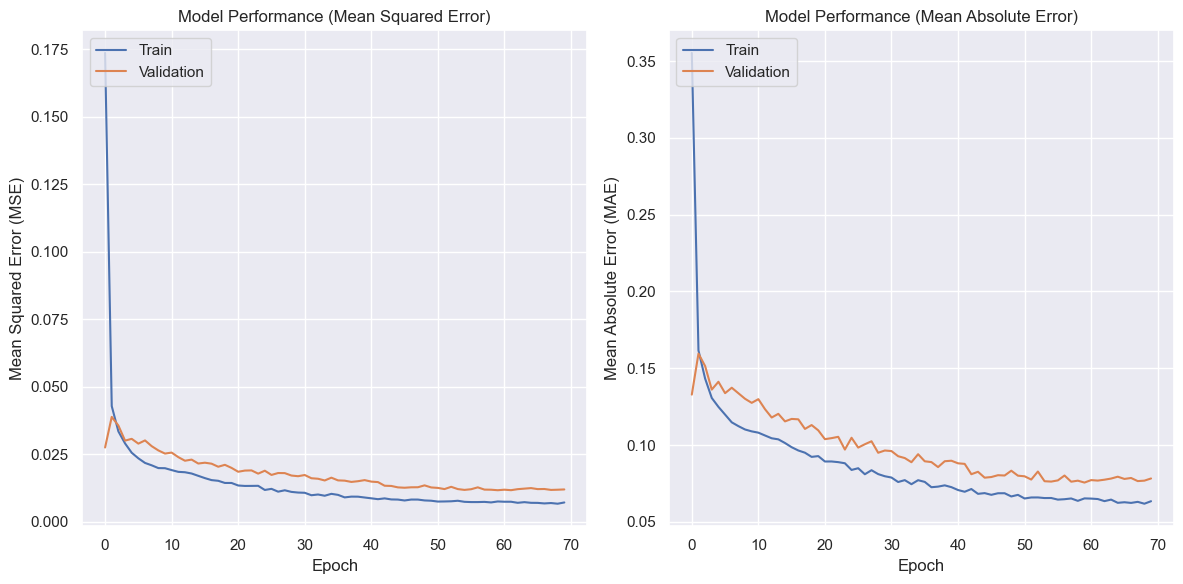

In [91]:
# Summarize history for Mean Squared Error (MSE) and Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))

# Plot for Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Train MSE')
plt.plot(final_history.history['val_loss'], label='Validation MSE')
plt.title('Model Performance (Mean Squared Error)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot for Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Train MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Model Performance (Mean Absolute Error)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Training model for PM1...


c:\Users\Sidhant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


PM1 - Test Loss (MSE): 0.00285, Test MAE: 0.04086

Training model for PM2.5...
PM2.5 - Test Loss (MSE): 0.00071, Test MAE: 0.02131

Training model for PM10...
PM10 - Test Loss (MSE): 0.00097, Test MAE: 0.02371

Training model for RH...
RH - Test Loss (MSE): 0.00706, Test MAE: 0.06564

Training model for Temperature...
Temperature - Test Loss (MSE): 0.01405, Test MAE: 0.09316

Training model for PM0.3...
PM0.3 - Test Loss (MSE): 0.00245, Test MAE: 0.03816



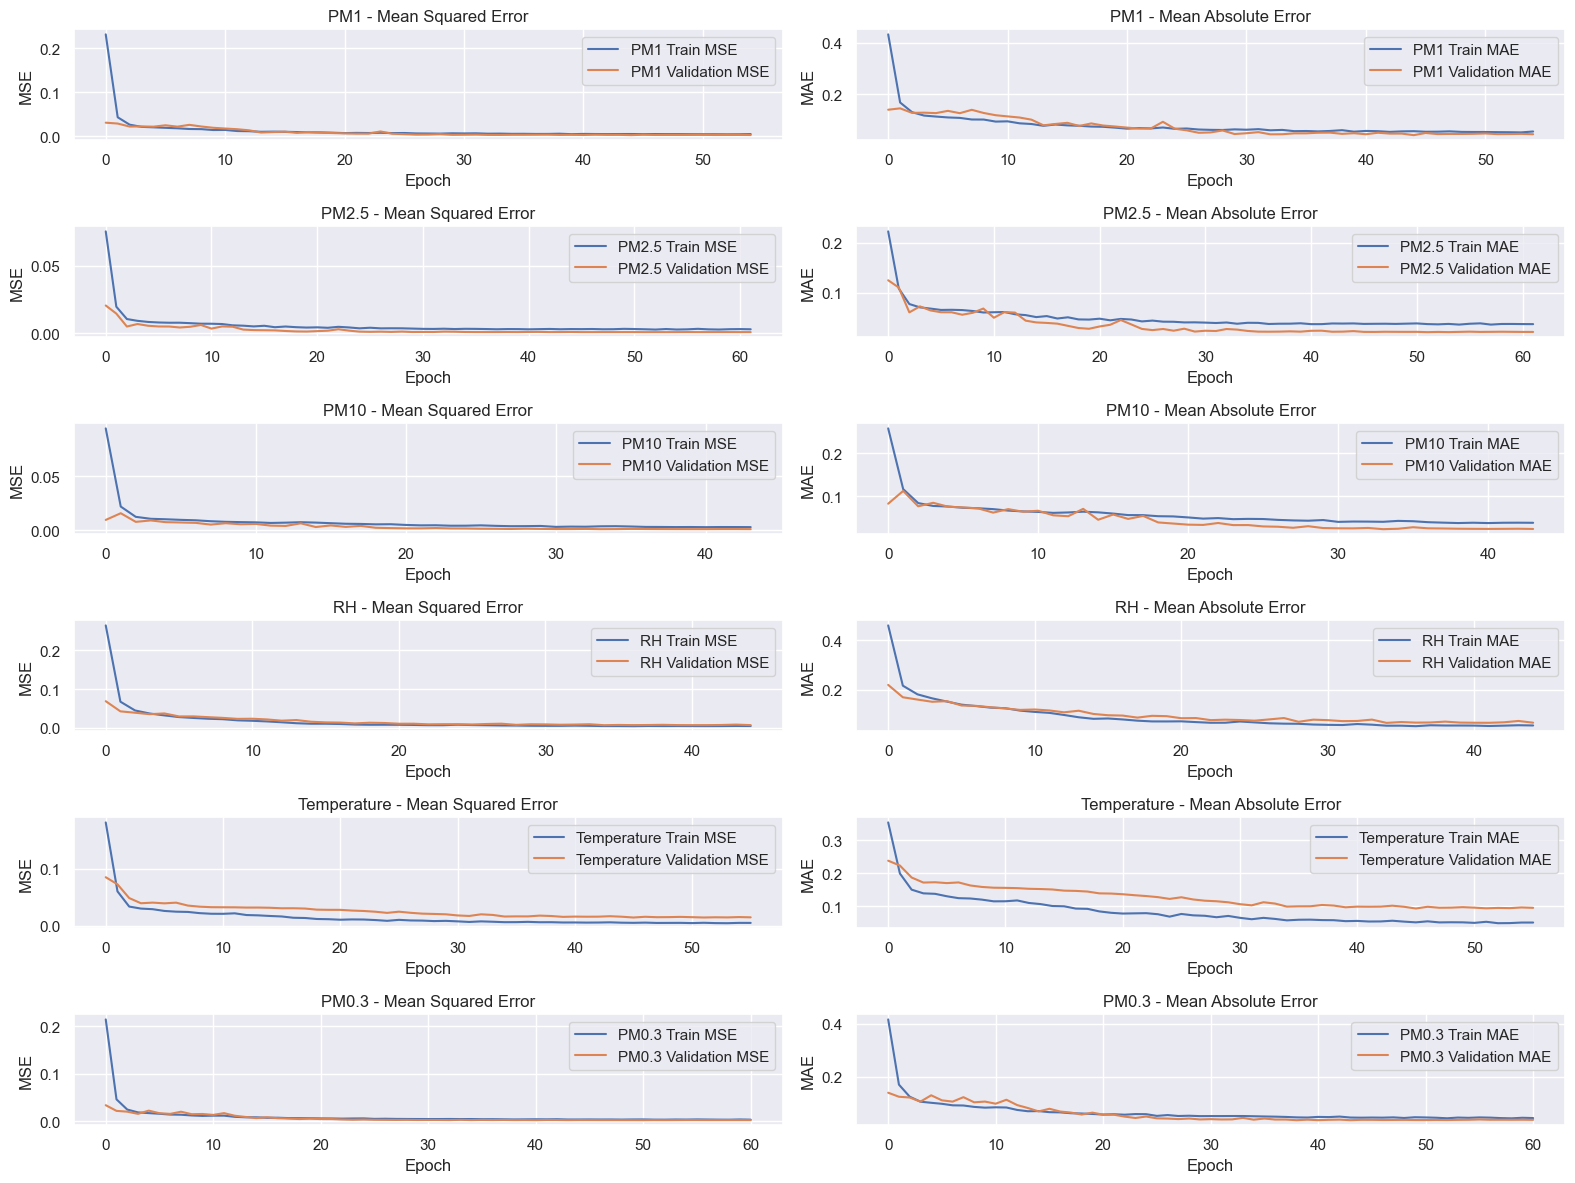

In [92]:
# Define a function to train and evaluate the model for all parameters
def train_and_evaluate_model(X_train, y_train, X_test, y_test, parameters):
    """
    Trains and evaluates an LSTM model for all air quality parameters.

    Args:
        X_train: Training input data.
        y_train: Training output data.
        X_test: Testing input data.
        y_test: Testing output data.
        parameters: List of air quality parameter names.
    """
    # Initialize a dictionary to store training histories for each parameter
    histories = {}

    # Iterate over each parameter (feature index)
    for i, parameter in enumerate(parameters):
        print(f"Training model for {parameter}...")

        # Extract the parameter data for training and testing
        y_train_param = y_train[:, i].reshape(-1, 1)
        y_test_param = y_test[:, i].reshape(-1, 1)

        # Define the model
        model = create_optimized_lstm_model((X_train.shape[1], X_train.shape[2]), dropout_rate=0.3)

        # Train the model
        history = model.fit(
            X_train, y_train_param,
            validation_data=(X_test, y_test_param),
            epochs=5000,
            batch_size=32,
            verbose=0,
            callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0),
                       EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)]
        )

        # Save the history for plotting
        histories[parameter] = history

        # Evaluate the model on the test set
        test_loss = model.evaluate(X_test, y_test_param, verbose=0)
        print(f"{parameter} - Test Loss (MSE): {test_loss[0]:.5f}, Test MAE: {test_loss[1]:.5f}\n")

    return histories

# List of air quality parameter names
parameters = ['PM1', 'PM2.5', 'PM10', 'RH', 'Temperature', 'PM0.3']

# Train and evaluate the model for each parameter
histories = train_and_evaluate_model(X_train, y_train, X_test, y_test, parameters)

# Plot the training and validation losses for all parameters
plt.figure(figsize=(16, 12))
for i, parameter in enumerate(parameters):
    history = histories[parameter]

    # Plot MSE (Loss)
    plt.subplot(len(parameters), 2, 2 * i + 1)
    plt.plot(history.history['loss'], label=f'{parameter} Train MSE')
    plt.plot(history.history['val_loss'], label=f'{parameter} Validation MSE')
    plt.title(f'{parameter} - Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # Plot MAE
    plt.subplot(len(parameters), 2, 2 * i + 2)
    plt.plot(history.history['mae'], label=f'{parameter} Train MAE')
    plt.plot(history.history['val_mae'], label=f'{parameter} Validation MAE')
    plt.title(f'{parameter} - Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.tight_layout()
plt.show()


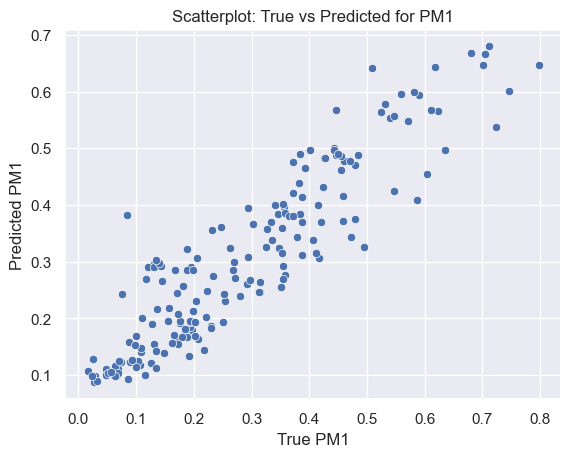

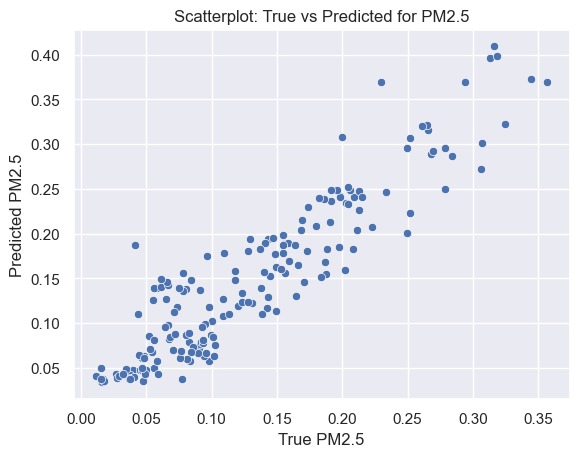

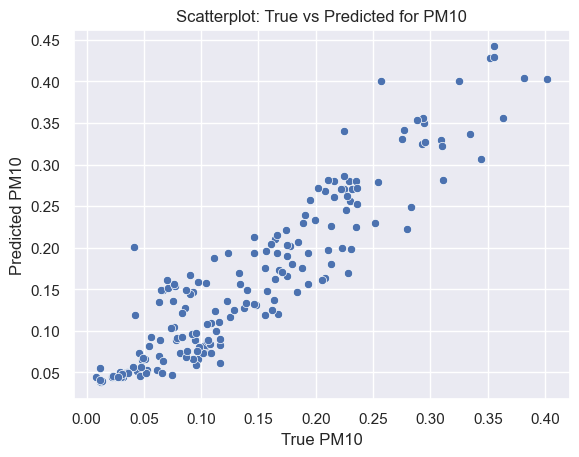

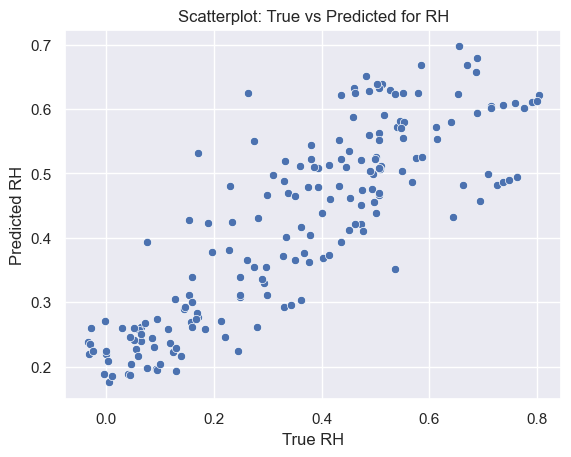

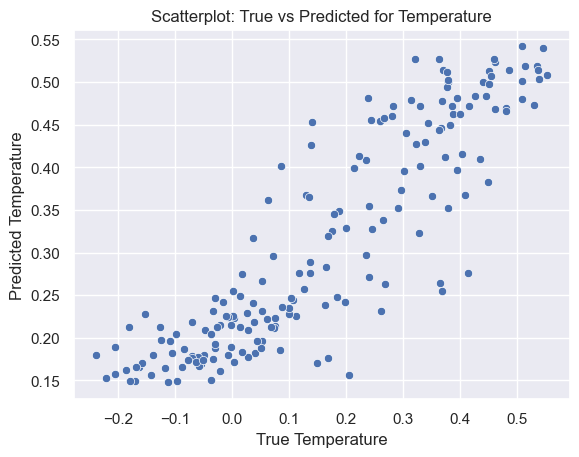

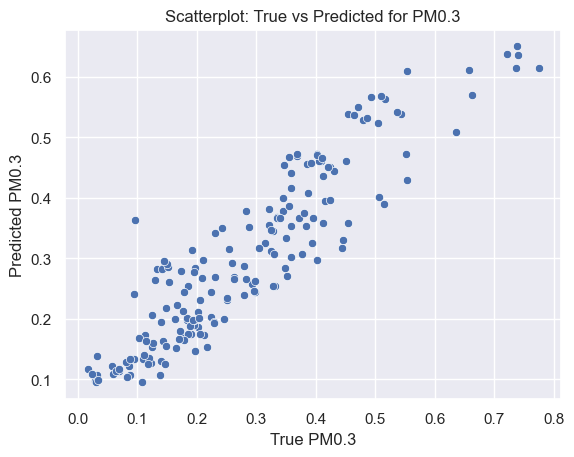

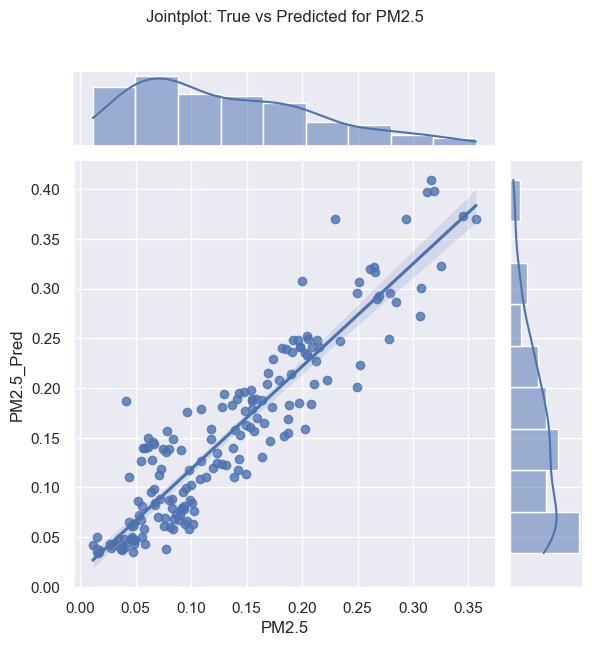

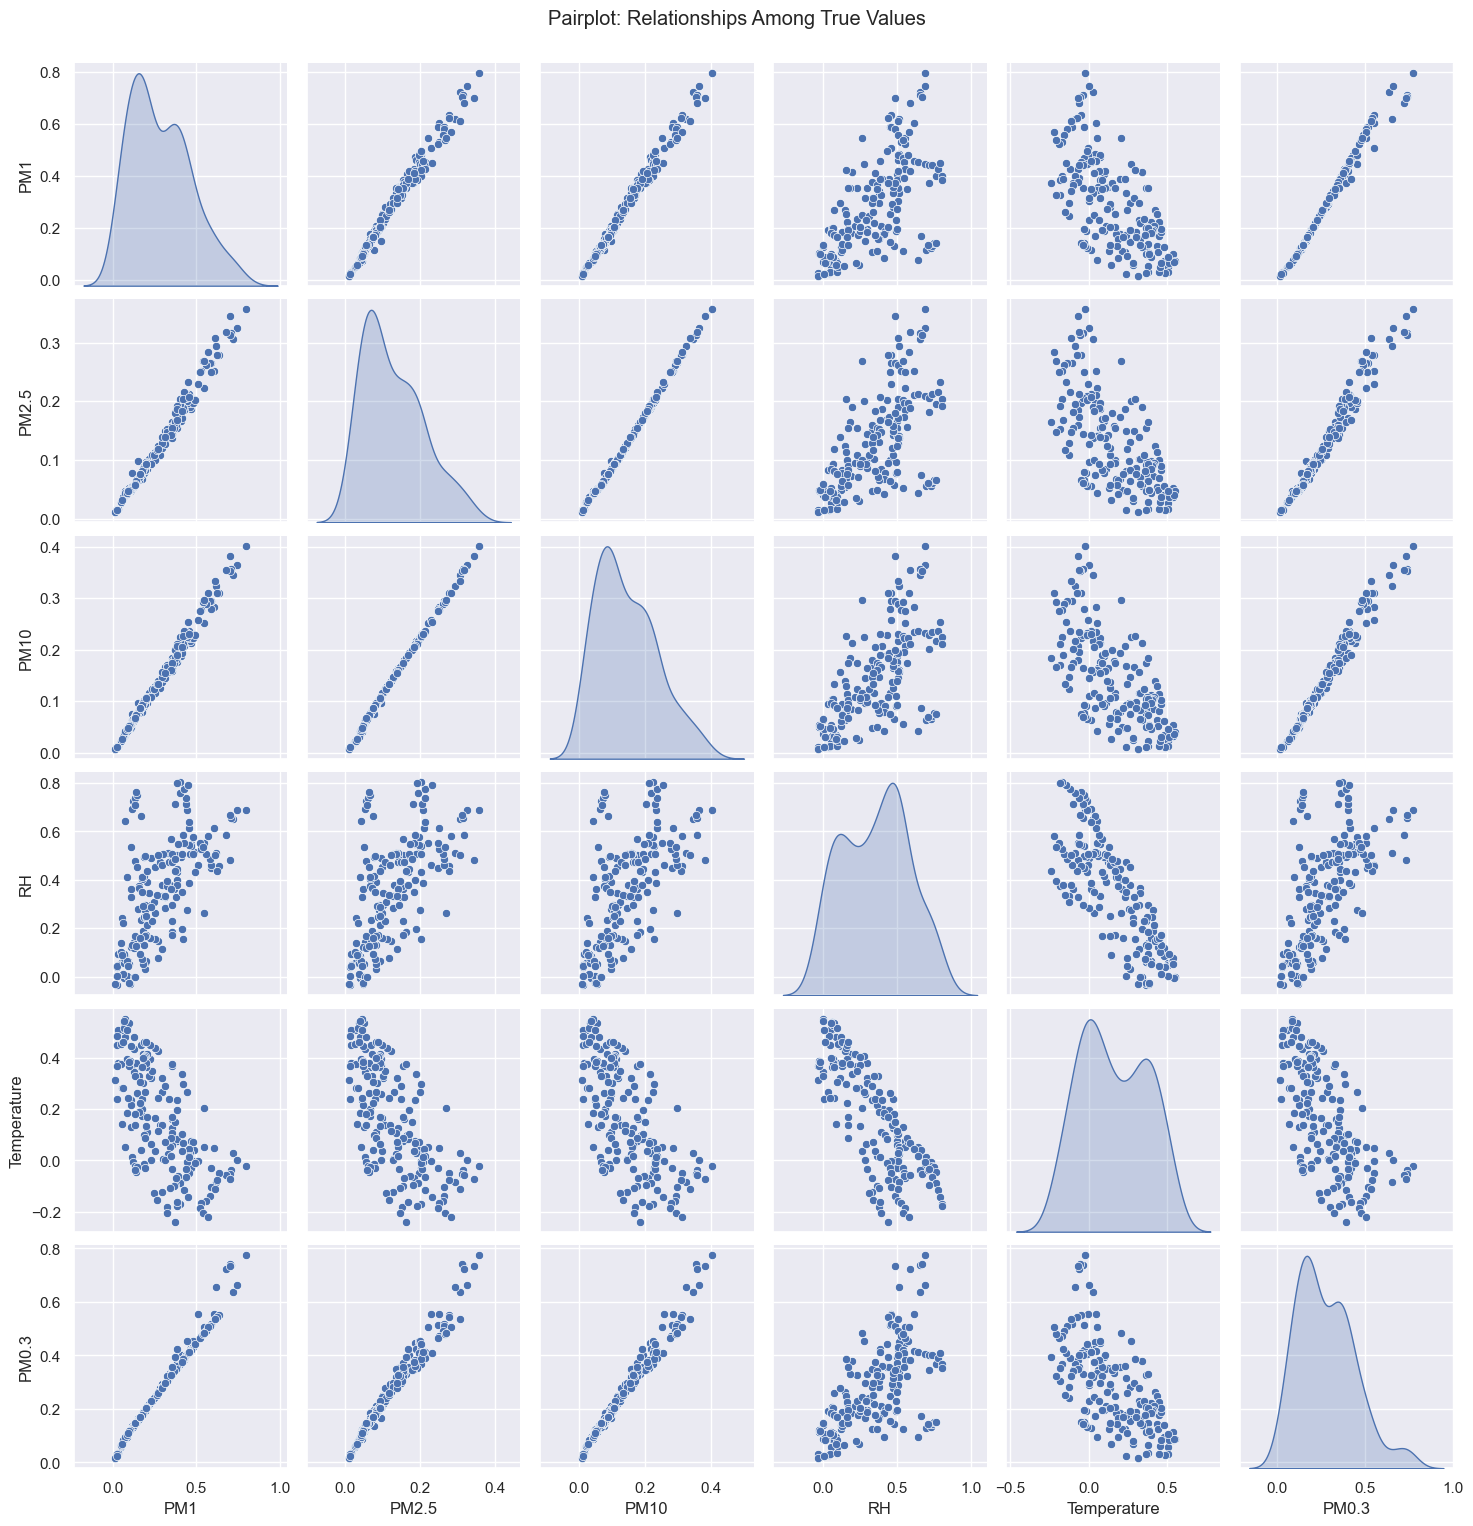

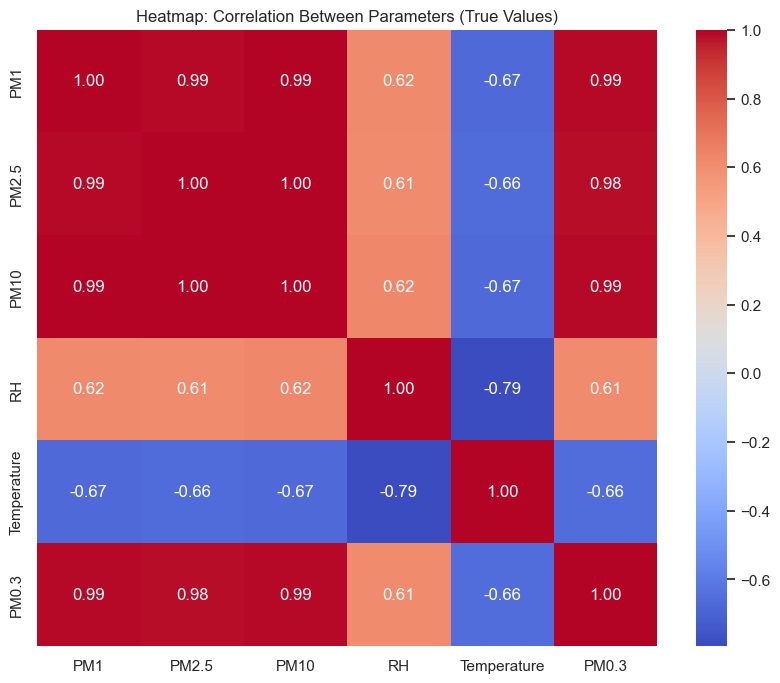

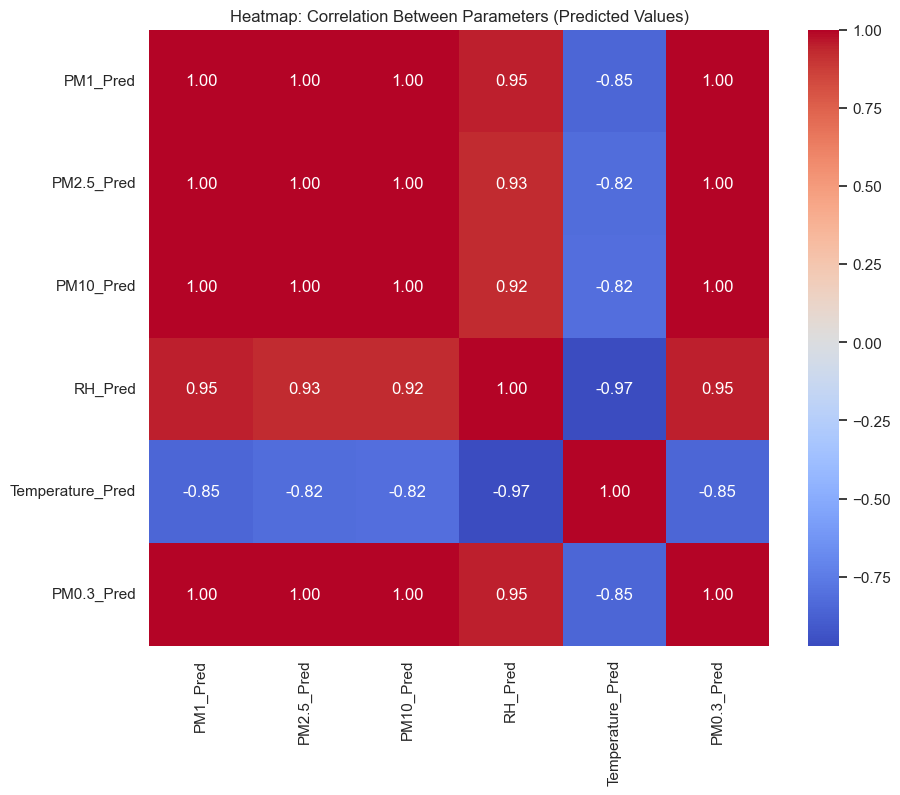

In [93]:
# Combine true and predicted values for visualization
visualization_data = pd.DataFrame(y_test, columns=['PM1', 'PM2.5', 'PM10', 'RH', 'Temperature', 'PM0.3'])
visualization_data_pred = pd.DataFrame(y_test_pred, columns=['PM1_Pred', 'PM2.5_Pred', 'PM10_Pred', 'RH_Pred', 'Temperature_Pred', 'PM0.3_Pred'])

# Merge true and predicted data
merged_data = pd.concat([visualization_data, visualization_data_pred], axis=1)

# Scatterplot: True vs Predicted for each parameter
for param in ['PM1', 'PM2.5', 'PM10', 'RH', 'Temperature', 'PM0.3']:
    sns.scatterplot(x=merged_data[param], y=merged_data[f"{param}_Pred"])
    plt.title(f"Scatterplot: True vs Predicted for {param}")
    plt.xlabel(f"True {param}")
    plt.ylabel(f"Predicted {param}")
    plt.show()

# Jointplot: True vs Predicted values for PM2.5
sns.jointplot(x='PM2.5', y='PM2.5_Pred', data=merged_data, kind='reg', height=6)
plt.title("Jointplot: True vs Predicted for PM2.5", pad=100)
plt.show()

# Pairplot: True values of all parameters
sns.pairplot(visualization_data, diag_kind='kde', height=2.5)
plt.suptitle("Pairplot: Relationships Among True Values", y=1.02)
plt.show()

# Heatmap: Correlation of true values
plt.figure(figsize=(10, 8))
correlation_matrix = visualization_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Heatmap: Correlation Between Parameters (True Values)")
plt.show()

# Heatmap: Correlation of predicted values
plt.figure(figsize=(10, 8))
correlation_matrix_pred = visualization_data_pred.corr()
sns.heatmap(correlation_matrix_pred, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Heatmap: Correlation Between Parameters (Predicted Values)")
plt.show()